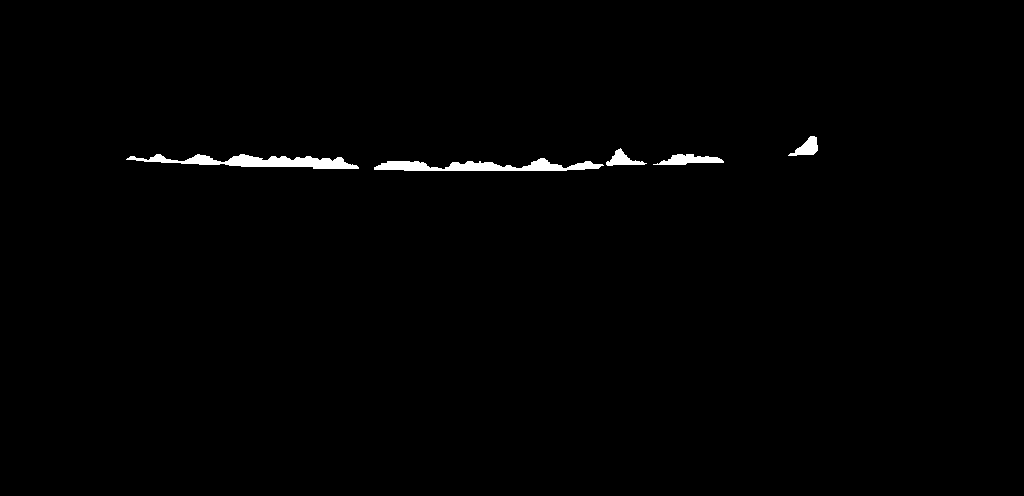

In [1]:
import shutil, os
import matplotlib.pyplot as plt
plt.style.use('ybpres.mplstyle')
from PIL import Image
import numpy as np
img = Image.open('../cera-rpd-train/data_RPDHimeesh_20210318/valid/images/all/101113_OS_oct-039.png')
img_mask = Image.open('../cera-rpd-train/data_RPDHimeesh_20210318/valid/masks/all/101113_OS_msk-039.png')
img_binary = Image.open('../cera-rpd-train/data_RPDHimeesh_combined/valid/masks/all/101113_OS_msk-039.png')
img_binary

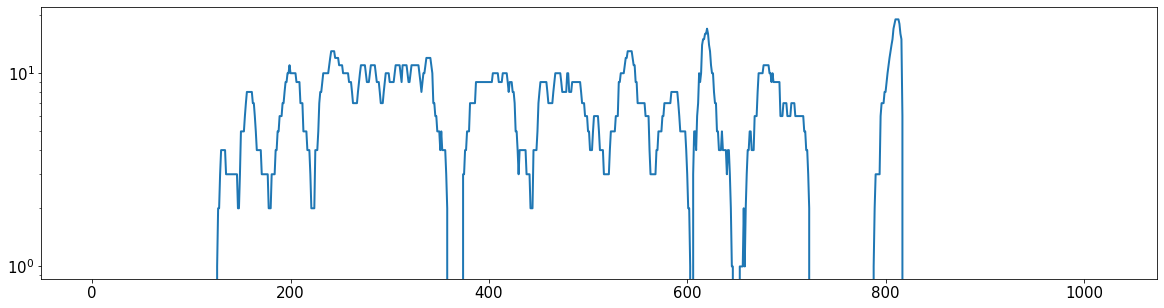

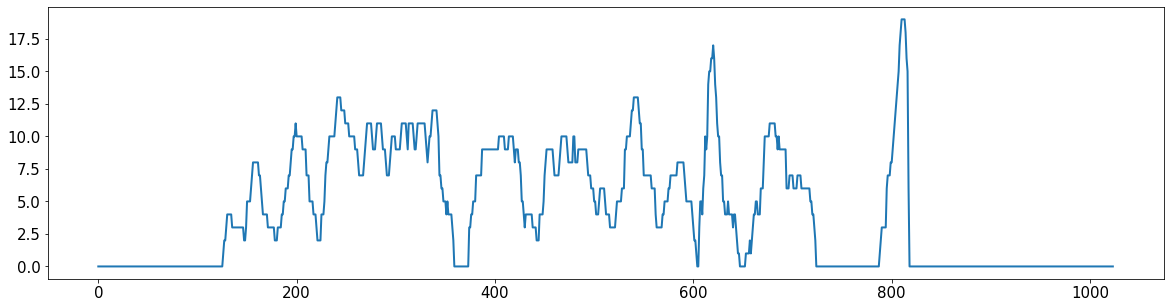

In [2]:
im = np.asarray(img_binary)
im = im/im.max()
y = im.sum(axis=0).astype(int)
x = np.arange(len(y))
fig,ax2 = plt.subplots(1,1,figsize=[20,5])
ax2.plot(y)



Continuous segments: [(126, 359), (374, 604), (606, 647), (653, 724), (788, 818)]
Identified instances within each segment:
[(150, 171), (185, 220), (225, 357)]
[(376, 430), (445, 516), (522, 563), (569, 600)]
[(607, 640)]
[(661, 722)]
[(795, 818)]


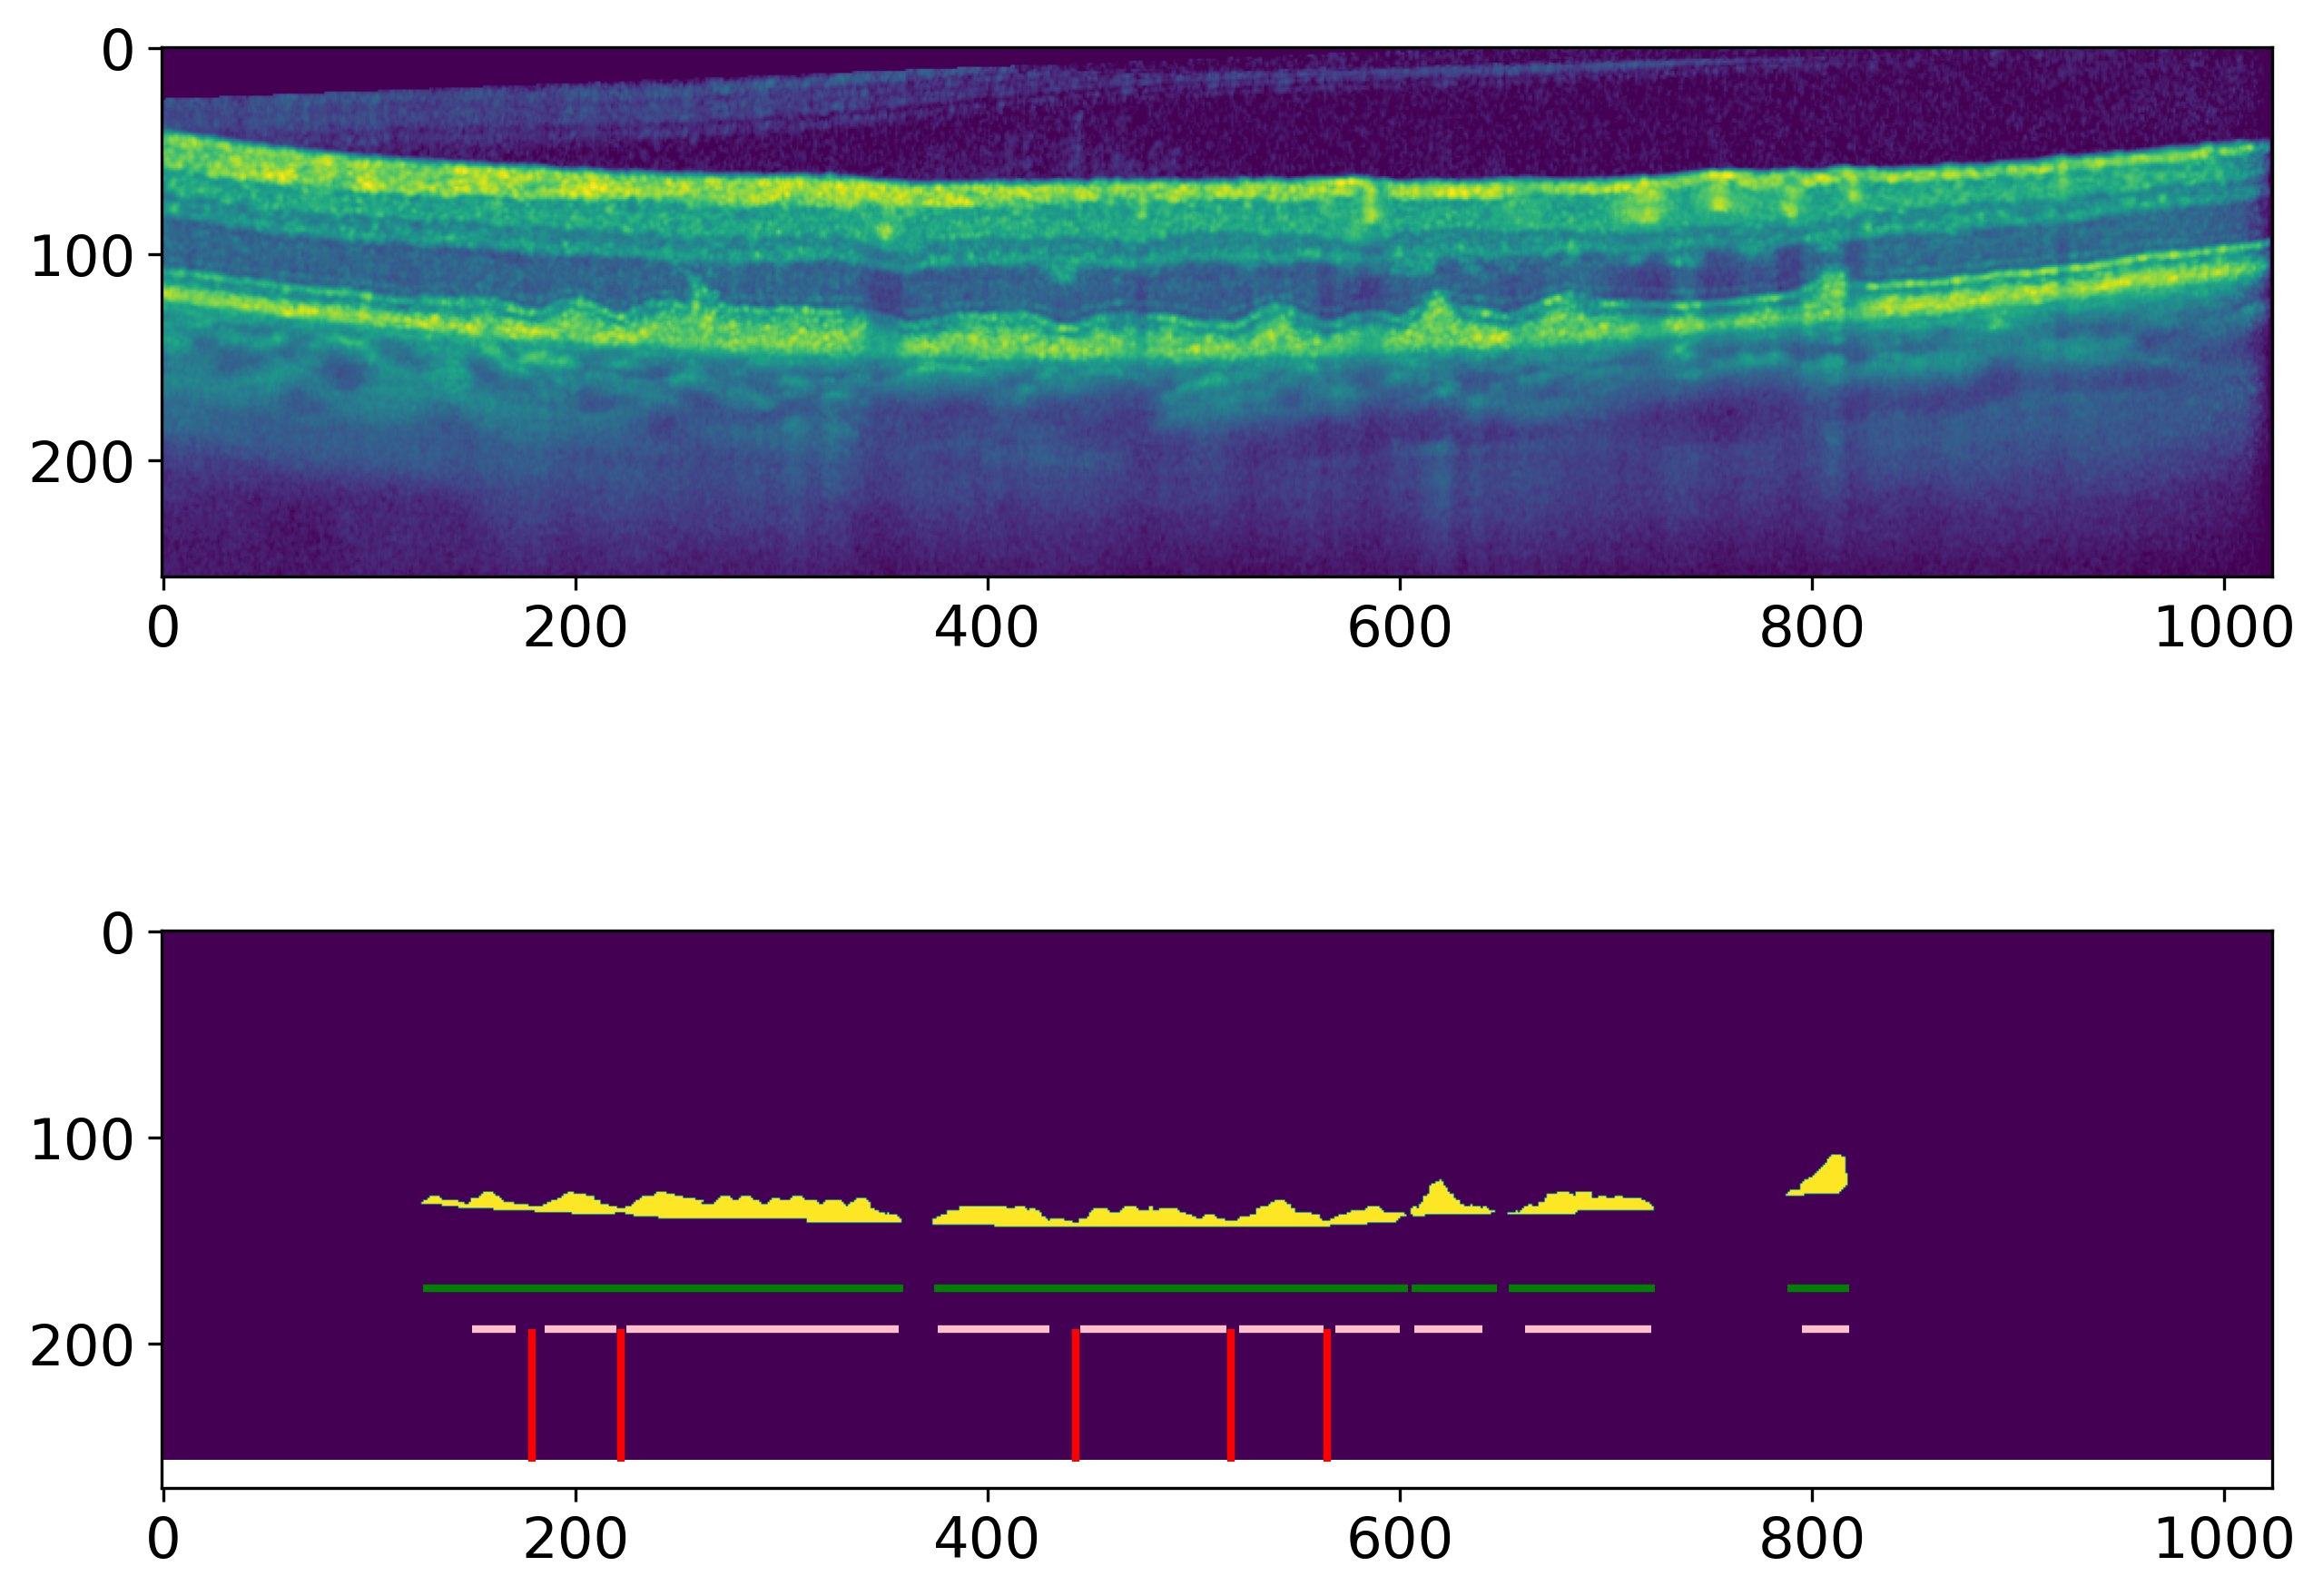

In [5]:
import pandas as pd
from datasets.data import findSegments,findBumps,findBoundaries,visualize_breakup

df = pd.DataFrame(y,columns=['y'])
segs = findSegments(df)
print('Continuous segments:', segs)

bumps = findBumps(df,segs,thresh=3)
print('Identified instances within each segment:')
[print(bump) for bump in bumps];

idx = findBoundaries(df,bumps)
fig,ax = visualize_breakup(np.array(img),im,segs,bumps,idx)

In [13]:
from detectron2.structures import BoxMode
import cv2
ret,binseg = cv2.threshold(im.astype('uint8')*255, 128, 255, cv2.THRESH_BINARY)
#apply instance delineation
# for i in idx:
#     binseg[:,i]=0
_, contours, hierarchy = cv2.findContours(binseg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
annotations = []
for c in contours:
    #instances += 1
    x,y,w,h = cv2.boundingRect(c)
    anot = dict(bbox = (x,y,w,h), 
        bbox_mode = BoxMode.XYWH_ABS, 
        category_id = 0, 
        segmentation = [c.flatten().tolist()])
    annotations.append(anot)

(496, 1024)


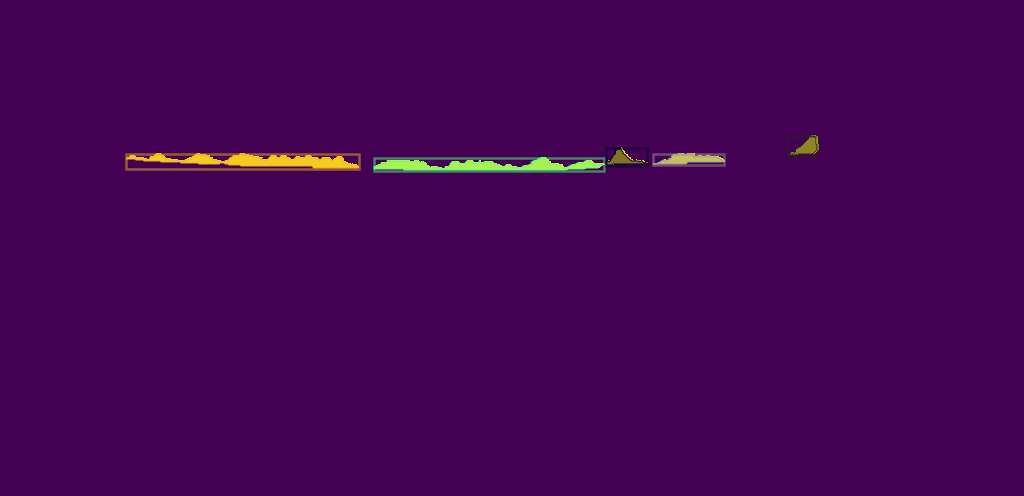

In [14]:
import detectron2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog,MetadataCatalog
bboxes = [ddict['bbox'] for ddict in annotations]
BBoxes = detectron2.structures.Boxes(bboxes)
BBoxes = detectron2.structures.BoxMode.convert(BBoxes.tensor,from_mode=1,to_mode=0) #1= XYXY, 2 = XYWH
segs = [ddict['segmentation'] for ddict in annotations]

v = Visualizer(im.astype('uint8')*255, MetadataCatalog.get("rpd_valid"), scale=1.0)
result_image = v.overlay_instances(boxes=BBoxes,masks=segs).get_image()
img = Image.fromarray(result_image)
print(im.shape)
img


In [12]:
import cv2
imm = cv2.imread('../cera-rpd-train/data_RPDHimeesh_combined/valid/masks/all/101113_OS_msk-039.png')[:, :, 0]

ret,binseg = cv2.threshold(imm, 128, 255, cv2.THRESH_BINARY)
_, contours, hierarchy = cv2.findContours(binseg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [16]:
type(fig)

matplotlib.figure.Figure